# YaneuraOu.dll

やねうら王をdllにして他のアプリケーションから使いましょう。

## dll読み込みと初期化

まずはdllを読み込みinit()を呼び出します。

In [1]:
from ctypes import cdll
import ctypes
from ctypes import *


dll = cdll.LoadLibrary('./YaneuraOu-2018-TNK.dll')  # 作成したdllの読み込み
dll.init()

0

## 組み込み関数を呼び出す

探索を行うには評価関数の読み込みが必須ですが、  
まずは評価関数なしでも使える組み込み関数を使ってみよう。

In [2]:
dll.elorating.restype = c_double
dll.elorating.argtypes = [c_double]
print(f"勝率0.95のときのレーティング差は {dll.elorating(0.95)}")
dll.inv_elorating.restype = c_double
dll.inv_elorating.argtypes = [c_double]
print(f"レーティング差-1000のときの勝率は {dll.inv_elorating(-1000)}")
dll.eval_winrate.restype = c_double
dll.eval_winrate.argtypes = [c_int]
print(f"評価値-1000のときの勝率は {dll.eval_winrate(-1000)}")
dll.inv_eval_winrate.restype = c_double
dll.inv_eval_winrate.argtypes = [c_double]
print(f"勝率0.95のときの評価値は {dll.inv_eval_winrate(0.95)}")
dll.rand_u32.restype = c_uint
print(f"u32乱数発生: {dll.rand_u32()}")
dll.rand_u64.restype = c_uint64
print(f"u64乱数発生: {dll.rand_u64()}")
dll.rand_r.restype = c_uint
dll.rand_r.argtypes = [c_uint]
print(f"[0,1000)の乱数発生: {dll.rand_r(1000)}")

勝率0.95のときのレーティング差は 511.50144038113143
レーティング差-1000のときの勝率は 0.0031523091832602115
評価値-1000のときの勝率は 0.15886910488091516
勝率0.95のときの評価値は 1766.663387499865
u32乱数発生: 533955917
u64乱数発生: 7588310414837633275
[0,1000)の乱数発生: 322


## 評価関数の読み込み

T.N.K.をベースとしているのでdll直下のディレクトリに「./eval/nn.bin」を置きます。  
isready()で評価関数を読み込むのですが、  
その前に「Threads」と「Hash」のオプション設定が最低限必要です。  
ついでに「NetworkDelay」「NetworkDelay2」も設定しておこう。

In [3]:
char_length = 256
# optionの設定
def setoption(option_: str, value_: str):
    b_option = option_.encode('utf-8') + b'\x00'
    CharArray1 = c_char * len(b_option)
    char_ptr1 = CharArray1(*[i for i in b_option])
    
    b_value = value_.encode('utf-8') + b'\x00'
    CharArray2 = c_char * len(b_value)
    char_ptr2 = CharArray2(*[i for i in b_value])
    
    dll.setoption(char_ptr1, len(b_option) - 1, char_ptr2, len(b_value) - 1)
    print(f"(setoption)")
    print(f"{char_ptr1[0:len(b_option) - 1].decode('utf-8')}")
    print(f"{char_ptr2[0:len(b_value) - 1].decode('utf-8')}")

# optionの取得
def getoption(option_: str):
    b_option = option_.encode('utf-8') + b'\x00'
    CharArray1 = c_char * len(b_option)
    char_ptr1 = CharArray1(*[i for i in b_option])
    
    CharArray2 = c_char * char_length
    char_ptr2 = CharArray2(*[0 for i in range(char_length)])
    
    result = dll.getoption(char_ptr1, len(b_option) - 1, char_ptr2, char_length)
    return char_ptr2[0:result].decode('utf-8')

setoption("Threads", "12")
setoption("Hash", "2048")
setoption("NetworkDelay", "0")
setoption("NetworkDelay2", "0")
Threads = getoption("Threads")
print(f"Threadsは「{Threads}」です。")

(setoption)
Threads
12
(setoption)
Hash
2048
(setoption)
NetworkDelay
0
(setoption)
NetworkDelay2
0
Threadsは「12」です。


## 盤面の読み込み

初期設定が終わったのでいよいよ評価関数を読み込んで盤面を表示してみよう。   
以下の盤面表示にはsfen文字列を介してShogiNotebookのplotを使って行うこととする。

In [4]:
from ShogiNotebook import Board


dll.isready()


# positionをセットする
def position(position: str):
    b_position = position.encode('utf-8') + b'\x00'
    CharArray = c_char * len(b_position)
    char_ptr = CharArray(*[i for i in b_position])

    dll.position(char_ptr, len(b_position) - 1,)
    print(f"(position)")
    print(f"{char_ptr[0:len(b_position) - 1].decode('utf-8')}")


# positionの取得
def get_position():
    CharArray = c_char * char_length
    char_ptr = CharArray(*[0 for i in range(char_length)])

    b = dll.get_position(char_ptr, char_length - 1,)
    return char_ptr[0:b].decode('utf-8')

(position)
sfen l2s2+p2/p1s5k/6pPp/P1+P6/2pp1P3/4+pp1p1/1p+p2SN2/1R1+n3SL/8K b B3G2N2Prbg2lp 1
sfenは'l2s2+p2/p1s5k/6pPp/P1+P6/2pp1P3/4+pp1p1/1p+p2SN2/1R1+n3SL/8K b B3G2N2Prbg2lp 1'です。
評価値は「2484」です。


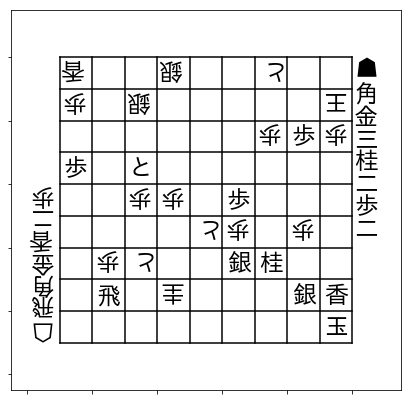

sfenは'l6nl/5+P1gk/2np1S3/p1p4Pp/3P2Sp1/1PPb2P1P/P5GS1/R8/LN4bKL w RGgsn5p 1'です。
評価値は「-752」です。


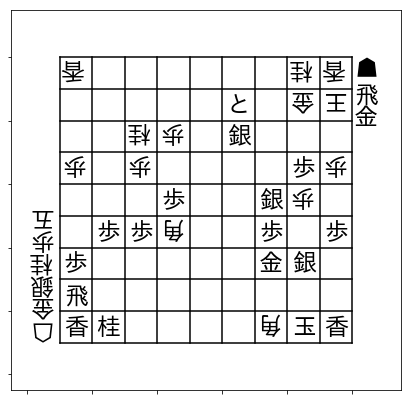

In [5]:
position("sfen l2s2+p2/p1s5k/6pPp/P1+P6/2pp1P3/4+pp1p1/1p+p2SN2/1R1+n3SL/8K b B3G2N2Prbg2lp 1")
print(f"sfenは'{get_position()}'です。")
print(f"評価値は「{dll.eval()}」です。")
Board.Board(f"sfen {get_position()}").plot()
dll.matsuri()
print(f"sfenは'{get_position()}'です。")
print(f"評価値は「{dll.eval()}」です。")
Board.Board(f"sfen {get_position()}").plot()

In [12]:
# moveの取得
def movelist():
    CharArray = c_char * 7200
    char_ptr = CharArray(*[0 for i in range(7200)])

    b = dll.movelist(char_ptr, 7200 - 1)
    return char_ptr[0:b].decode('utf-8').split(" ")

print(f"指し手は{len(movelist())}通りです。")
print(movelist())

指し手は157通りです。
['4d4c+', '4d4c', '5d5c+', '5d5c', '8e8d', '9e9d', '1i1g', '1i1h', '9i9f', '9i9g', '9i9h', '8i7g', '8i9g', '5e4f', '5e6d', '6b5a+', '6b5a', '6b5c+', '6b5c', '6b6a+', '6b6a', '6b7a+', '6b7a', '6b7c+', '6b7c', '1c1b', '1c1d', '1c2b', '1c2c', '5f4e', '5f4f', '5f5g', '5f6e', '6f6e', '6f6g', '6f7e', '6f7f', '8c7b', '8c7c', '8c8b', '8c8d', '8c9b', '8c9c', '8f7e', 'B*9h', '8f7g', '8f8g', '8f9f', 'N*9h', 'P*1b', 'P*1e', 'P*1h', 'P*2b', 'P*2c', 'P*2e', 'P*2f', 'P*2h', 'P*2i', 'P*3b', 'P*3c', 'P*3e', 'P*3g', 'P*3h', 'P*6c', 'P*6d', 'P*6g', 'P*6h', 'P*6i', 'P*7b', 'P*7c', 'P*7d', 'P*7f', 'P*7g', 'P*7h', 'P*7i', 'B*1a', 'B*2a', 'B*3a', 'B*4a', 'B*5a', 'B*6a', 'B*7a', 'B*1b', 'B*2b', 'B*3b', 'B*7b', 'B*9b', 'N*1e', 'B*1e', 'N*1h', 'B*1h', 'N*2c', 'B*2c', 'N*2e', 'B*2e', 'N*2f', 'B*2f', 'N*2h', 'B*2h', 'N*2i', 'B*2i', 'N*3c', 'B*3c', 'N*3e', 'B*3e', 'N*3g', 'B*3g', 'N*3h', 'B*3h', 'N*4f', 'B*4f', 'N*4g', 'B*4g', 'N*4h', 'B*4h', 'N*4i', 'B*4i', 'N*5c', 'B*5c', 'N*5g', 'B*5g', 'N*5h', 'B*

## 探索を行う

探索はgo関数を呼び出します。  
引数は最初の2つがbestmove文字列格納用のポインタ。  
そこから順に、思考時間(ミリ秒)、入玉ルール(24(デフォルト), 27, 0(なし), 1(トライ))  
最大手数、最大深さ、最大ノード、詰将棋エンジンでの思考時間(0だと詰将棋エンジンではない)

In [7]:
# go
def go():
    CharArray = c_char * char_length
    char_ptr = CharArray(*[0 for i in range(char_length)])

    b = dll.go(char_ptr, char_length - 1, 1000, 24, 0, 0, 0, 0)
    return char_ptr[0:b].decode('utf-8').split(" ")

In [8]:
position("sfen l6nl/5+P1gk/2np1S3/p1p4Pp/3P2Sp1/1PPb2P1P/P5GS1/R8/LN4bKL w RGgsn5p 1")
print(go())
position("sfen l2s2+p2/p1s5k/6pPp/P1+P6/2pp1P3/4+pp1p1/1p+p2SN2/1R1+n3SL/8K b B3G2N2Prbg2lp 1")
print(go())

(position)
sfen l6nl/5+P1gk/2np1S3/p1p4Pp/3P2Sp1/1PPb2P1P/P5GS1/R8/LN4bKL w RGgsn5p 1
['1d1e']
(position)
sfen l2s2+p2/p1s5k/6pPp/P1+P6/2pp1P3/4+pp1p1/1p+p2SN2/1R1+n3SL/8K b B3G2N2Prbg2lp 1
['2c2b+']


## ランダム局面の生成

ランダム局面生成関数を呼び出してみる。

バイト数: 81
sfen lp7/1r1Spk3/1+P3g2+P/4PPsgl/PPppSp3/pK1GG1p1+p/7+pn/9/LN2+n1+s1L b 2BNPr2p 1
(position)
sfen lp7/1r1Spk3/1+P3g2+P/4PPsgl/PPppSp3/pK1GG1p1+p/7+pn/9/LN2+n1+s1L b 2BNPr2p 1
['4d4c+']


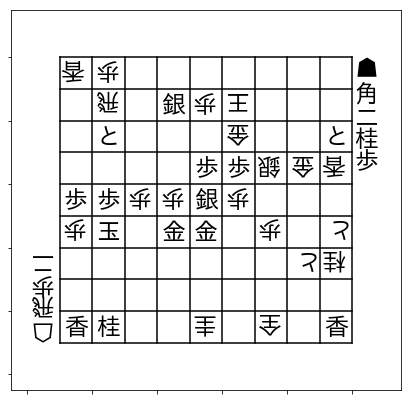

In [11]:
def random_sfen():
    CharArray = c_char * char_length
    char_ptr = CharArray(*[0 for i in range(char_length)])
    b = dll.random_sfen(char_ptr, char_length)
    return f"sfen {char_ptr[0:b].decode('utf-8')}"

sfen = random_sfen()
print(f"バイト数: {len(sfen)}")
print(f"{sfen}")
position(sfen)
print(go())
Board.Board(sfen).plot()

# 将棋に関する統計関数

## シミュレーション

### 対局シミュレーション

binomial()関数は勝率$p$で対局数$times$の時の対局をシミュレーションする。  
返り値は勝数で対局結果は引数のchar配列に返る。

In [25]:
def binomial(p: float, times: int):
    CharArray = c_char * (times + 1)
    char_ptr = CharArray(*[0 for i in range(times + 1)])

    b = dll.binomial(c_double(p), char_ptr, times)
    result = ""
    for c in char_ptr:
        result += "0" if c == b'\x00' else "1"
    return b, result[:-1]

binomial(0.80, 100)

(80,
 '1111111110010001111011111111111111111101111010111100101111011110111111111100111101110110111111111011')

sim_battle()関数は対局数battle_numでレーティング差diff_ratingの時の対局をシミュレーションする。  
なお先後に有利不利があるとして、もしレーティング差が0のときの先手勝率をblack_winrateとして与える。  
返り値は勝率。

In [48]:
def sim_battle(battle_num: int, diff_rating: float, black_winrate: float):
    return dll.sim_battle(battle_num, diff_rating, black_winrate)

dll.sim_battle.restype = c_double
dll.sim_battle.argtypes = [c_uint, c_double, c_double]
print(f"対局数を変えると……")
print(f"100局： {sim_battle(100, 200, 0.53)}")
print(f"1000局： {sim_battle(1000, 200, 0.53)}")
print(f"10000局： {sim_battle(10000, 200, 0.53)}")
print(f"100000局： {sim_battle(100000, 200, 0.53)}")
print(f"レーティング差を変えると……")
print(f"R差100： {sim_battle(10000, 100, 0.53)}")
print(f"R差400： {sim_battle(10000, 400, 0.53)}")
print(f"R差1000： {sim_battle(10000, 1000, 0.53)}")
print(f"R差2000： {sim_battle(10000, 2000, 0.53)}")
print(f"先手勝率を変えると……")
print(f"先手勝率0.5： {sim_battle(10000, 400, 0.5)}")
print(f"先手勝率0.6： {sim_battle(10000, 400, 0.6)}")
print(f"先手勝率0.7： {sim_battle(10000, 400, 0.7)}")
print(f"先手勝率0.8： {sim_battle(10000, 400, 0.8)}")
print(f"先手勝率0.9： {sim_battle(10000, 400, 0.9)}")

対局数を変えると……
100局： 0.67
1000局： 0.78
10000局： 0.7586
100000局： 0.75796
レーティング差を変えると……
R差100： 0.6407
R差400： 0.9094
R差1000： 0.9968
R差2000： 1.0
先手勝率を変えると……
先手勝率0.5： 0.9103
先手勝率0.6： 0.9083
先手勝率0.7： 0.8879
先手勝率0.8： 0.8483
先手勝率0.9： 0.7552


## 区間推定

対局結果からレーティングの区間推定を行う。

In [67]:
def infar_rating(win: int, lose: int, draw: int, draw_half: bool, p: float):
    lower = c_double()
    lower_ptr = pointer(lower)
    upper = c_double()
    upper_ptr = pointer(upper)
    dll.infar_rating(
        win, lose, draw, lower_ptr, upper_ptr, draw_half, p
    )
    return lower.value, upper.value

dll.infar_rating.argtypes = [c_uint64, c_uint64, c_uint64, POINTER(c_double), POINTER(c_double), c_bool, c_double]

print(f"200勝150敗20分で66%幅は: {infar_rating(200, 150, 20, True, 0.66)}")
print(f"2000勝1500敗200分で66%幅は: {infar_rating(2000, 1500, 200, True, 0.66)}")
print(f"200勝150敗20分で95%幅は: {infar_rating(200, 150, 20, True, 0.95)}")
print(f"2000勝1500敗200分で95%幅は: {infar_rating(2000, 1500, 200, True, 0.95)}")
print(f"200勝150敗20分で99%幅は: {infar_rating(200, 150, 20, True, 0.99)}")
print(f"2000勝1500敗200分で99%幅は: {infar_rating(2000, 1500, 200, True, 0.99)}")

200勝150敗20分で66%幅は: (26.967702407949222, 62.61611192917245)
2000勝1500敗200分で66%幅は: (39.346339097443526, 50.23230978191556)
200勝150敗20分で95%幅は: (9.228369740327459, 80.59395513589538)
2000勝1500敗200分で95%幅は: (33.715399195571436, 55.886364888630716)
200勝150敗20分で99%幅は: (-1.6161410120520223, 91.66222199463681)
2000勝1500敗200分で99%幅は: (30.269889694456413, 59.35366308905081)
